
## **Project Abstract** ## 
To help people get started on their project and to make sure you are selecting an appropriate task, we will have all the teams submit an abstract. Please only submit one abstract per team.

The abstract should include (at least):

-Team members

-Problem statement

-Data you will use to solve the problem

-Outline of how you plan on solving the problem with the data. For example, what pre-processing steps might you need to do, what models, etc.

-Supporting documents if necessary citing past research in the area and methods used to solve the problem.

-The goal of this abstract is for you to think deeply about the project you will be undertaking and convince yourself (and us) that it is a meaningful and achievable project for this class.

This homework is due March 1, 2018 by midnight Utah time. and will be submitted on learning suite.

# Airbnb New User Bookings

## Team Members

- Alex Fabiano 
- Michael Clawson
- Elijah Broadbent 


## Problem Statement



With 34,000+ cities across 190+ countries, Airbnb users have a multitude of destinations from which to choose.  This vast array of possibilities creates problems for both users and Airbnb. New users may suffer choice overload and prolong their first booking. Irregular and prolonged first bookings can cause demand lags and inhibit demand predictability for Airbnb.
	
The goal of this data project is to accurately predict where new users will book their first Airbnb. This will enable Airbnb to share more personalized content and better forecast demand as well as improve user experience.


## Data

The data for this project comes from four separate files containing age and gender buckets, countries, websession, and a user set.  We will need to join the users and sessions sets into a training set while the remaining sets will serve as supplementary information to inform our data cleaning and analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# from sklearn.metrics import f1_score, classification_report, accuracy_score, make_scorer
plt.rcParams['figure.figsize'] = [10,8]

In [117]:
test = pd.read_csv('test_users.csv')
#XY_Age = pd.read_csv('age_gender_bkts.csv') #complicated and messy...consider doing last
#countries = pd.read_csv('countries.csv')
users = pd.read_csv('train_users_2.csv')
sessions = pd.read_csv('sessions.csv')

Note that other refers to bookings made to a country not on this list while NDF corresponds to sessions in which no booking was ultimately made.

In [118]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [119]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [120]:
# joined = pd.merge(users, sessions, left_on='id', right_on='user_id', how='inner')
# joined.head()

In [121]:
print("Sessions Length: {}\tUsers Length: {}".format(len(sessions), len(users)))

Sessions Length: 10567737	Users Length: 213451


Now that we have merged our data together we can address cleaning it and begin engineering the features we want to use in our model.

## Data Cleaning and Feature Engineering

In [122]:
users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

We have a lot of object types in our data that will need to be transformed if we choose to use them.  Let's set aside the variables we want to drop and the ones we want to convert into dummy variables.

In [123]:
# Create drop and dummy arrays
drop = []
dummies = []

In [124]:
# Displays the columns with null values and the percent of null values for each column
print("Columns\t\t\t % Null")
users[users.columns[users.isnull().any()]].isnull().sum()/len(users)

Columns			 % Null


date_first_booking         0.583473
age                        0.412226
first_affiliate_tracked    0.028414
dtype: float64

In [126]:
users.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [127]:
users.country_destination.value_counts(normalize=True, dropna=False)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

Date of booking null values indicate that no booking was ever made, so a high proportion of nulls in this category is no surprise. Age is the only glaring null-value issue with the data, as over 30% of values are missing. We may be able to find a way to fill these values with the average age conditional on the users other observable characteristics; e.g. female mac owners who use chrome.

**Date Account Created**

In [128]:
users.date_account_created.describe() #Need to extract usable variables

count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object

In [129]:
users.date_account_created = pd.to_datetime(users.date_account_created) #Casts object as datetime
test.date_account_created = pd.to_datetime(test.date_account_created)

In [130]:
# Create indicators for day of week (0=Mon, 6=Sun) account was created
users['day_of_week_created'] = users.date_account_created.dt.weekday
test['day_of_week_created'] = test.date_account_created.dt.weekday
# Create indicators for day of month (0 through 31), month, and year account created
users['day_of_month_created'] = users['date_account_created'].dt.day
test['day_of_month_created'] = test['date_account_created'].dt.day
users['month_created'] = users['date_account_created'].dt.month
test['month_created'] = test['date_account_created'].dt.month
users['year_created'] = users['date_account_created'].dt.year
test['year_created'] = test['date_account_created'].dt.year

In [131]:
drop.append('date_account_created')

Do we really want date of first booking? It seems a bit silly to predict where people are booking when we already have the date. If we want to present something that's more realistic, we might want to try to predict based on historical info.

-- I think you make an excellent point...we should ask Tyler after class

-- I think we should put it in the model and let the model decide if it's useful.

According to Maria, we should not include the date of the first booking because the model will use that variable alone to predict, and new test data won't have that variable.

**Date First Booking**

In [132]:
#Create variable for whether a user booked at all
#joined['Booked?'] = np.where(joined['date_first_booking'].isnull(), 0, 1) 

In [133]:
#joined.date_first_booking = pd.to_datetime(joined.date_first_booking)

In [134]:
#joined['day_of_week_1stbook'] = joined['date_first_booking'].dt.weekday
#joined['day_of_month_1stbook'] = joined['date_first_booking'].dt.day
#joined['month_1stbook'] = joined['date_first_booking'].dt.month
#joined['year_1stbook'] = joined['date_first_booking'].dt.year

In [135]:
drop.append('date_first_booking')

**Gender**

In [136]:
#What can we intuit from the gender variable?
users['gender'].value_counts(normalize=True, dropna=False)

-unknown-    0.448290
FEMALE       0.295342
MALE         0.255047
OTHER        0.001321
Name: gender, dtype: float64

Unknown should be kept as a variable, and should not try to fill, given that it is very likely that the model will see unknown genders in the test set. 

In [137]:
dummies.append('gender')#??? only make dummies for 3 of them

**Age**

In [138]:
users.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [139]:
print("% Individuals older than 100: {}".format(sum((users.age > 100)/len(users.age)).round(4)))
print("% Individuals younger than 18: {}".format((sum(users.age < 18)/len(users.age)).round(4)))

% Individuals older than 100: 0.011
% Individuals younger than 18: 0.0007


According to the age distribution statistics, it appears that the data contains individuals with implausible ages exceeding 120 years. We may be better suited to only include individuals under the age of 100 in our analysis and modeling.

In [140]:
# Statistics on individuals with age less than 100
users[users.age<100]['age'].describe()

count    123090.000000
mean         36.530937
std          11.673194
min           1.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          99.000000
Name: age, dtype: float64

Text(0.5,1,'Age Distribution')

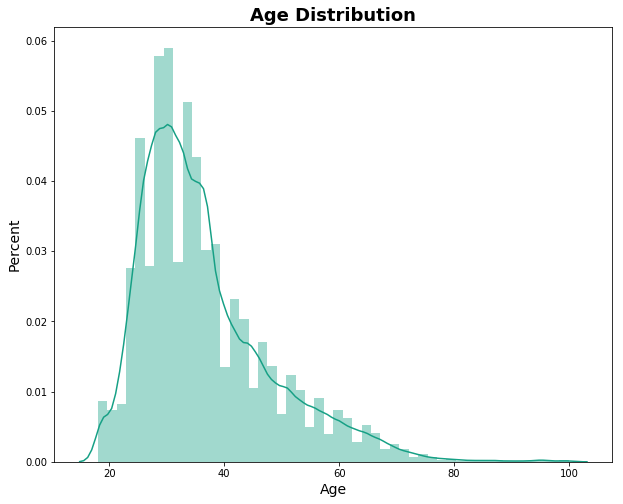

In [141]:
train_mean_age = users[(users.age<100) & (users.age>18)].age.mean()
sns.distplot(users['age'].apply(lambda x : train_mean_age if x>100 or x < 18 else x).dropna(), color='#16A085')
plt.xlabel('Age', fontsize=14)  #Consider titling simply 'Age'
plt.ylabel('Percent', fontsize=14)
plt.title('Age Distribution', fontsize=18, fontweight='bold')

Most of our dataset is comprised of 25-40-year-olds, and there is a small number of users that are younger than Airbnb terms of service allow to book rooms.  We will also have to do address the bizarre ages in the thousands.

In [142]:
#Change all unusable ages to NaN:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 18, 'age'] = np.nan
test.loc[test.age > 95, 'age'] = np.nan
test.loc[test.age < 18, 'age'] = np.nan
# Airbnb users must be 18 by law...so does 13 make sense?

Will need to revisit age variable after we've looked at the other variables that we could possibly extrapolate more targeted age data from.

In [143]:
# Here is a neat way to impute missing age values
train_std_age = users[(users.age<100) & (users.age>18)].age.std()
rand1 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=users.age.isnull().sum())
randt = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=test.age.isnull().sum())

In [144]:
# Create a series to preserve the indices of NaNs
users['age'] = users['age'].fillna(pd.Series(rand1, users[users['age'].isnull()].index))
test['age'] = test['age'].fillna(pd.Series(randt, test[test.age.isnull()].index))

**Signup Method**

In [145]:
#??? Should this be made into dummies or not?
users['signup_method'].value_counts(normalize=True, dropna=False)

basic       0.716310
facebook    0.281132
google      0.002558
Name: signup_method, dtype: float64

Signup Method is a rather straightforward dummy case, and there are no null values to fill in for, as per the null value analysis done previously in the notebook.

In [146]:
dummies.append('signup_method')

**Signup Flow**

The web page from which a user came to signup (discrete variable).

In [147]:
users['signup_flow'].value_counts(normalize=True, dropna=False) #What is signup flow?

0     0.771788
25    0.068676
12    0.043706
3     0.041330
2     0.032237
24    0.020276
23    0.013282
1     0.004905
6     0.001410
8     0.001124
21    0.000918
5     0.000169
20    0.000066
16    0.000052
15    0.000047
10    0.000009
4     0.000005
Name: signup_flow, dtype: float64

In [148]:
dummies.append('signup_flow')

**Language**

In [149]:
users.language.value_counts(normalize=True, dropna=False)

en    0.966564
zh    0.007646
fr    0.005491
es    0.004287
ko    0.003500
de    0.003429
it    0.002408
ru    0.001822
pt    0.001124
ja    0.001054
sv    0.000572
nl    0.000454
tr    0.000300
da    0.000272
pl    0.000253
cs    0.000150
no    0.000141
th    0.000112
el    0.000112
id    0.000103
hu    0.000084
fi    0.000066
ca    0.000023
is    0.000023
hr    0.000009
Name: language, dtype: float64

Since 96% of all users speak English, the language variable may provide little insight. Making dummies for all of the languages seems illogical. We could consider creating dummies for English (eh), Chinese (zh), Korean (ko), and an 'other' category.

In [150]:
users.language = users.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
test.language = test.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')

In [151]:
dummies.append('language')

**Affiliate Channel**

In [152]:
users.affiliate_channel.value_counts(normalize=True, dropna=False)

direct           0.645239
sem-brand        0.122019
sem-non-brand    0.088283
other            0.041982
seo              0.040585
api              0.038262
content          0.018496
remarketing      0.005135
Name: affiliate_channel, dtype: float64

In [153]:
dummies.append('affiliate_channel')

**Affiliate Provider**

In [154]:
users.affiliate_provider.value_counts(normalize=True, dropna=False)

direct                 0.643829
google                 0.242177
other                  0.058791
craigslist             0.016261
bing                   0.010906
facebook               0.010649
vast                   0.003884
padmapper              0.003598
facebook-open-graph    0.002553
yahoo                  0.002324
gsp                    0.002122
meetup                 0.001626
email-marketing        0.000778
naver                  0.000244
baidu                  0.000136
yandex                 0.000080
wayn                   0.000037
daum                   0.000005
Name: affiliate_provider, dtype: float64

In [155]:
#??? Either make dummies for all or only the categories consisting of more than 3%
users.affiliate_provider = users.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
test.affiliate_provider = test.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
dummies.append('affiliate_provider')

**First Affiliate Tracked**

First marketing interacted with by the user before signing up.

In [156]:
users.first_affiliate_tracked.value_counts(normalize=True, dropna=False)

untracked        0.511743
linked           0.216851
omg              0.206052
tracked-other    0.028840
NaN              0.028414
product          0.007290
marketing        0.000651
local ops        0.000159
Name: first_affiliate_tracked, dtype: float64

In [157]:
# Fills null values with variable mode, which is 'untracked'
users.first_affiliate_tracked.fillna(value='{}'.format(users.first_affiliate_tracked.mode()[0]),inplace=True)
test.first_affiliate_tracked.fillna(value='{}'.format(users.first_affiliate_tracked.mode()[0]),inplace=True)

In [158]:
dummies.append('first_affiliate_tracked')

**Signup App**

In [159]:
users.signup_app.value_counts(normalize=True, dropna=False)

Web        0.856014
iOS        0.089102
Moweb      0.029332
Android    0.025552
Name: signup_app, dtype: float64

In [160]:
dummies.append('signup_app')

**First Device Type**

In [161]:
users.first_device_type.value_counts(normalize=True, dropna=False)

Mac Desktop           0.419768
Windows Desktop       0.340668
iPhone                0.097254
iPad                  0.067177
Other/Unknown         0.049974
Android Phone         0.013132
Android Tablet        0.006053
Desktop (Other)       0.005617
SmartPhone (Other)    0.000356
Name: first_device_type, dtype: float64

In [162]:
dummies.append('first_device_type')

**First Browser**

In [163]:
users.first_browser.value_counts(normalize=True, dropna=False)

Chrome                  0.299108
Safari                  0.211613
Firefox                 0.157671
-unknown-               0.127739
IE                      0.098702
Mobile Safari           0.090297
Chrome Mobile           0.005950
Android Browser         0.003987
AOL Explorer            0.001148
Opera                   0.000881
Silk                    0.000581
Chromium                0.000342
BlackBerry Browser      0.000248
Maxthon                 0.000216
IE Mobile               0.000169
Apple Mail              0.000169
Sogou Explorer          0.000155
Mobile Firefox          0.000141
SiteKiosk               0.000112
RockMelt                0.000112
Iron                    0.000080
IceWeasel               0.000061
Pale Moon               0.000056
SeaMonkey               0.000052
Yandex.Browser          0.000052
CometBird               0.000052
Camino                  0.000042
TenFourFox              0.000037
CoolNovo                0.000028
wOSBrowser              0.000028
Avant Brow

In [164]:
users.first_browser = users.first_browser.apply(lambda x: x if str(x) == 'Chrome' or str(x) == 'Safari' or
                                                 str(x) == '-unknown-' or str(x) == 'Firefox' or 
                                                  str(x) == 'Mobile Safari' or str(x) == 'IE' else 'other')
test.first_browser = test.first_browser.apply(lambda x: x if str(x) == 'Chrome' or str(x) == 'Safari' or
                                                 str(x) == '-unknown-' or str(x) == 'Firefox' or 
                                                  str(x) == 'Mobile Safari' or str(x) == 'IE' else 'other')

In [165]:
dummies.append('first_browser')

**Where possible, we should make sure the 'NDF' group is comparable on other observable characteristics. We can go back and add visualizations in the data cleaning section**

In [166]:
users.country_destination.value_counts(normalize=True, dropna=False)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [168]:
users.drop(drop, axis=1, inplace=True)

In [170]:
users = pd.get_dummies(users, columns=dummies)

In [171]:
users.shape

(213451, 73)

In [172]:
users.drop('id', axis=1, inplace=True)

## Modeling

In [177]:
#Create train/test split
target = users.country_destination
users.drop(['country_destination'], axis=1, inplace=True)
xtrain, xtest, ytrain, ytest = train_test_split(users, target, test_size=0.2, random_state=42)
print("%d items in training data, %d items in test data" % (len(xtrain), len(xtest)))

170760 items in training data, 42691 items in test data


### K-Neighbors Classifier

In [181]:
% time
kn_clf = KNeighborsClassifier()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [228]:
% time
gridsearch_kn2 = GridSearchCV(kn_clf, {"n_neighbors": [3,5,7], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]})
gridsearch_kn2.fit(xtrain, ytrain)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [229]:
print("Best Parameters: {}".format(gridsearch_kn2.best_params_))

Best Parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}


In [230]:
knclf_ypredict_train2 = gridsearch_kn2.predict(xtrain)

In [231]:
print("Training Accuracy Score: {}".format(metrics.accuracy_score(ytrain, knclf_ypredict_train2)))

Training Accuracy Score: 0.6085148746779105


In [232]:
knclf_ypredict_test2 = gridsearch_kn.predict(xtest)

In [233]:
print("Test Accuracy Score: {}".format(metrics.accuracy_score(ytest, knclf_ypredict_test2)))

Test Accuracy Score: 0.5491321355789276


In [196]:
#print("Best Parameters: {}".format(gridsearch_kn.best_params_))
#knclf_ypredict_train = gridsearch_kn.predict(xtrain)
#print("Training F1 Score: {}".format(f1_score(ytrain, knclf_ypredict_train)))

#print("Test Classification Report:")
#knclf_ypredict_test = gridsearch_kn.predict(xtest)
#print(classification_report(ytest, knclf_ypredict_test))

#print("Train Accuracy: {}\nTest Accuracy: {}".format(accuracy_score(ytrain, knclf_ypredict_train), 
 #                                                    accuracy_score(ytest, knclf_ypredict_test)))

# Project Research

Based on the other Kaggle kernels for this project, a few different methods have been used to predict first booking location for new Airbnb users. Some competitors utilized the ensemble technique, incorporating up to three layers. One kaggler implemented a three tiered ensemble with six different models in each layer (Support Vector Machines, Logistic Regression, Random Forest, Gradient Boosting, Extra Trees Classifier, and K-Nearest Neighbors). Another kaggler coded a Normalized Discounted Cumulative Gain model, or NDCG, which is a type of ranking measure. This model relies on a logarithmic discounting factor and has achieved significant empirical results. However, little is known about the theoretical properties of NDCG models. Further information can be found at https://arxiv.org/abs/1304.6480 .

# Strategy

After merging our data and doing a minimal amount of initial cleaning, we will use a K-Neighbors Classifier to get a naive baseline for our classification problem.  From there we will modify our cleaning as needed to account for outliers, missing data, and optimal control variables in a more robust fashion.  Other models we plan to consult include Random Forest, regression, and Gradient Boosting.  Depending on the results we obtain from these methods we can complicate our approach using tiered-ensembles of multiple models.